# Load in Image

This dataset is a sample from a larger research project. The sample comprises of 16 micrographs. Each micrograph was taken at different temperatures/pressure stored as seperate .jpg files.

## Aims

A program that can :
 
- `Upload`: an image of a micrograph 
- `Crop`: the image to only relevant area
- `Process`: Take scale bar to aid in comparison of images 
- `Process`: Identify indiviual Hydrides in microstructure  

## Import Packages

In [2]:
# We import the packages we need
from matplotlib import pyplot as plt
import re
from PIL import Image
import os, os.path
from os import listdir
import matplotlib.axes
import matplotlib.image as mpimg
import numpy as np
import cv2


# And also we import the functions we have created, which are in the packages folder
from packages import plot_image
from packages import Edge

## Import the images from github

- Import image [.jpg image] 
- Transpose the image to make the radial direction vertical. 
- Crop scale bar from image and/or crop image to a specific location. 
- Input Scale Bar Value, the scale bar will then be calculated.

In [3]:
def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)


The data should be placed in a sub-directory called `Micrographs`.

In [4]:
mypath = './Micrographs/'

def_files = sorted_aphanumeric(listdir(mypath))

In [5]:
img = cv2.imread('./Micrographs/chu16.jpg',0)

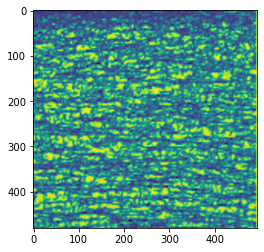

In [6]:
imgplot = plt.imshow(img)

## Image Processing

The images gained from the raw data is read with a BGR code through opencv instead of a RGB code. This doesn't matter as we will be transforming them into black and white images eventually. Due to the large area of the images being analysed, any standard connectivity methods will not work as every projection will have at least one hydride shadow. Therefore, we begin by breaking the image into vertical strips to reduce the effects of interference on measuring the radial HCC. Following from this we blur corresponding strips and save them in their own directorys.

In [7]:
#define the number of veritcal splits we require
SecNum = 15

#this small loop confirms that the total width of the image can be split into the defined number of sections, 
# if not another section will be added until equality is achieved
while True:
    if (np.size(img,1) % SecNum) !=0:
        SecNum += 1
    else:
        break

#introducing a tracker variable allows for simple passing of number of slices between chunks
tracker = 0

#this loop takes the image and vertically slices it in equal widths as defined above
for x in range(0,np.size(img,1),SecNum):
        x1 = x + SecNum
        section = img[0:np.size(img,0), x:x1]
        
        cv2.imwrite("ImagePrep/Sections/" + str(tracker) +".png",section)
        
        tracker +=1

#following from this, the slices are then blurred to reduce noise and transformed to their original black and white colour
for i in range(0,tracker):
    Sec = cv2.imread("./ImagePrep/Sections/" + str(i) + ".png")
    
    Sec = cv2.cvtColor(Sec,cv2.COLOR_BGR2RGB)
    
    Blur = cv2.GaussianBlur(Sec, (7,7),0)
    cv2.imwrite("ImagePrep/Blurs/" + str(i) +".png",Blur)

#while technically unnecessary, this stage restitches the blured slices to allow for viewing of the transformed image
    if i > 0:
        if i == 1:
            ImgL = cv2.imread("./ImagePrep/Blurs/" + str(i-1) + ".png")
            ImgR = cv2.imread("./ImagePrep/Blurs/" + str(i) + ".png")
            BlurJoin = np.concatenate((ImgL, ImgR), axis=1)
        else:
            ImgR = cv2.imread("./ImagePrep/Blurs/" + str(i) + ".png")
            BlurJoin = np.concatenate((BlurJoin, ImgR), axis=1)

cv2.imwrite('ImagePrep/BlurJoined.png', BlurJoin)


True

## Thresholding

This stage is to transform the image to be totally binary from the grayscale images saved and blured.
Use 3 different thresholding method and see which one works best .

Otsu method is first carried out.

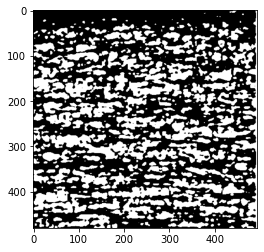

In [8]:
#using the tracker variable defined earlier, any actions can be repeated across the entirety of the slices easily
for i in range(tracker):
    Blur = cv2.imread("./ImagePrep/Blurs/" + str(i) + ".png", 0)
    
#Using the inbuilt opencv otsu thresholding method and defining it as a binary threshold, aka only black and white, 
# both a thresholded image is produced and the automatically detected thresholding value is found.   
    ThreshValue, ThreshOtsu = cv2.threshold(Blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cv2.imwrite("Thresholding/Otsu/" + str(i) +".png",ThreshOtsu)
    np.save("Thresholding/Otsu/" + str(i), ThreshOtsu)
    
#As earlier, the individual slices are saved to their own directory and an overall image is made from reattaching the slices.
    if i > 0:
        if i == 1:
            ImgL = cv2.imread("./Thresholding/Otsu/" + str(i-1) + ".png")
            ImgR = cv2.imread("./Thresholding/Otsu/" + str(i) + ".png")
            OtsuThresh = np.concatenate((ImgL, ImgR), axis=1)
        else:
            ImgR = cv2.imread("./Thresholding/Otsu/" + str(i) + ".png")
            OtsuThresh = np.concatenate((OtsuThresh, ImgR), axis=1)

cv2.imwrite('Thresholding/OtsuThresh.png', OtsuThresh)

plt.imshow(mpimg.imread('Thresholding/OtsuThresh.png'))

Next k-means is attempted

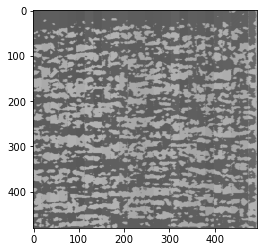

In [11]:
#As previously, the tracker variable is used to initiate the loop for the thresholding.
for i in range(tracker):
    ImgIn = cv2.imread("./ImagePrep/Blurs/" + str(i) + ".png",1)
    
    Blur = cv2.cvtColor(ImgIn, cv2.COLOR_BGR2GRAY)

    reshapedImage = np.float32(Blur.reshape(-1, 3))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)

#The number of channels is defined for the k-means method, as it's black and white "2" is chosen
    k = 2

    ret, labels, clusters = cv2.kmeans(reshapedImage, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    clusters = np.uint8(clusters)
    
    Sec = cv2.imread("./ImagePrep/Sections/" + str(i) + ".png")
    Sec = cv2.cvtColor(Sec,cv2.COLOR_BGR2GRAY)

    intermediateImage = clusters[labels.flatten()]
    clusteredImage = intermediateImage.reshape((Sec.shape))
    
    cv2.imwrite("Thresholding/Kmeans/" + str(i) +".png",clusteredImage)
    
#As earlier, the individual slices are saved to their own directory and an overall image is made from reattaching the slices.
    if i > 0:
        if i == 1:
            ImgL = cv2.imread("./Thresholding/Kmeans/" + str(i-1) + ".png")
            ImgR = cv2.imread("./Thresholding/Kmeans/" + str(i) + ".png")
            KThresh = np.concatenate((ImgL, ImgR), axis=1)
        else:
            ImgR = cv2.imread("./Thresholding/Kmeans/" + str(i) + ".png")
            KThresh = np.concatenate((KThresh, ImgR), axis=1)

cv2.imwrite("Thresholding/KThresh.png", KThresh)

plt.imshow(mpimg.imread('Thresholding/KThresh.png'))

## Connecivity of Microstructure 

Assess interconnectivity between hydrides in the radial direction. Using the literature review the formula for the HCC was discovered.

In [9]:
for i in range(tracker):
    
    imgO = cv2.imread("./Thresholding/Otsu/" + str(i) + ".png", 0)
    imgK = cv2.imread("./Thresholding/Kmeans/" + str(i) + ".png", 0)
    
    CannyImgO = Edge.auto_canny(imgO)
    CannyImgK = Edge.auto_canny(imgK)
    
    cv2.imwrite("Edges/Otsu/" + str(i) +".png",CannyImgO) 
    cv2.imwrite("Edges/Kmeans/" + str(i) +".png",CannyImgO) 
    
    if i > 0:
        if i == 1:
            ImgL = cv2.imread("./Edges/Otsu/" + str(i-1) + ".png")
            ImgR = cv2.imread("./Edges/Otsu/" + str(i) + ".png")
            EdgesO = np.concatenate((ImgL, ImgR), axis=1)
            
            ImgL = cv2.imread("./Edges/Kmeans/" + str(i-1) + ".png")
            ImgR = cv2.imread("./Edges/Kmeans/" + str(i) + ".png")
            EdgesK = np.concatenate((ImgL, ImgR), axis=1)
        else:
            ImgR = cv2.imread("./Edges/Otsu/" + str(i) + ".png")
            EdgesO = np.concatenate((EdgesO, ImgR), axis=1)
            
            ImgR = cv2.imread("./Edges/Kmeans/" + str(i) + ".png")
            EdgesK = np.concatenate((EdgesK, ImgR), axis=1)

cv2.imwrite("Edges/CannyOtsu.png", EdgesO)
cv2.imwrite("Edges/CannyKmeans.png", EdgesK)        

True

In [10]:
imgO = cv2.imread("./Edges/CannyOtsu.png", 0)
imgK = cv2.imread("./Edges/CannyKmeans.png", 0)

HydrideOtsu = 0
HydrideKmeans = 0

HCC_Otsu =[]
HCC_Kmeans = []

for i in range(np.size(imgO,1)):
    for j in range(np.size(imgO,0)):
        if imgO[j,i] > 0:
            HydrideOtsu += 1
    HCC_Otsu.append(HydrideOtsu/(np.size(imgO,0)))
    HydrideOtsu = 0
    
for i in range(np.size(imgK,1)):
    for j in range(np.size(imgK,0)):
        if imgK[j,i] > 0:
            HydrideKmeans += 1
    HCC_Kmeans.append(HydrideKmeans/(np.size(imgK,0)))
    HydrideKmeans = 0

AVG_HCC_Otsu = sum(HCC_Otsu)/len(HCC_Otsu)
AVG_HCC_Kmeans = sum(HCC_Kmeans)/len(HCC_Kmeans)

print(AVG_HCC_Otsu, AVG_HCC_Kmeans)

0.11011302294197034 0.11011302294197034


This next method will be using the edge detection images to discover the contours within the slices then measure the HCC of the slices and averaging them across the image

In [17]:
HCCrun_Otsu = []
HCCrun_Kmeans = []

for i in range(tracker):
    
    image_src_Otsu = cv2.imread("./Edges/Otsu/" + str(i) + ".png")

    gray = cv2.cvtColor(image_src_Otsu, cv2.COLOR_BGR2GRAY)
    ret, gray = cv2.threshold(gray, 250, 255,0)

    contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(image_src_Otsu.shape, np.uint8)
    largest_areas = sorted(contours, key=cv2.contourArea)
    cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
    removed = cv2.add(image_src_Otsu, mask)
    
    cv2.imwrite("Edges/ContOtsu/" + str(i) + ".png",removed) 
    
    cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    y5 = []
    h5 = []
    
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        y5.append(y)
        h5.append(h)
     
    for r in range(len(y5)):
        g = y5[r] + h5[r]
        for j in range(len(y5)):
            if r < j:
                q = y5[j] + h5[j]
                if q > y5[r]:
                    z = q - y5[r]
                    q = q-z
                    h5[j] = h5[j] - z
    
    HCCrun_Otsu.append((sum(h5))/(np.size(image_src_Otsu,0)))
    
    del cnts
    
    image_src_Kmeans = cv2.imread("./Edges/Kmeans/" + str(i) + ".png")

    gray_k = cv2.cvtColor(image_src_Kmeans, cv2.COLOR_BGR2GRAY)
    ret, gray_k = cv2.threshold(gray_k, 250, 255,0)

    contours, hierarchy = cv2.findContours(gray_k, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(image_src_Kmeans.shape, np.uint8)
    largest_areas = sorted(contours, key=cv2.contourArea)
    cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
    removed = cv2.add(image_src_Kmeans, mask)
    
    cv2.imwrite("Edges/ContKmeans/" + str(i) + ".png",removed) 
    
    cnts = cv2.findContours(gray_k, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    y5 = []
    h5 = []
    
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        y5.append(y)
        h5.append(h)
     
    for r in range(len(y5)):
        g = y5[r] + h5[r]
        for j in range(len(y5)):
            if r < j:
                q = y5[j] + h5[j]
                if q > y5[r]:
                    z = q - y5[r]
                    q = q-z
                    h5[j] = h5[j] - z
    
    HCCrun_Kmeans.append((sum(h5))/(np.size(image_src_Kmeans,0))) 
    
    if i > 0:
        if i == 1:
            ImgL = cv2.imread("./Edges/ContOtsu/" + str(i-1) + ".png")
            ImgR = cv2.imread("./Edges/ContOtsu/" + str(i) + ".png")
            ContOtsu = np.concatenate((ImgL, ImgR), axis=1)
            
            ImgL = cv2.imread("./Edges/ContKmeans/" + str(i-1) + ".png")
            ImgR = cv2.imread("./Edges/ContKmeans/" + str(i) + ".png")
            ContKmeans = np.concatenate((ImgL, ImgR), axis=1)
        else:
            ImgR = cv2.imread("./Edges/ContOtsu/" + str(i) + ".png")
            ContOtsu = np.concatenate((ContOtsu, ImgR), axis=1)
            
            ImgR = cv2.imread("./Edges/ContKmeans/" + str(i) + ".png")
            ContKmeans = np.concatenate((ContKmeans, ImgR), axis=1)

print("Otsu HCC: " + str(sum(HCCrun_Otsu)/len(HCCrun_Otsu)))
print("K-means HCC: " + str(sum(HCCrun_Kmeans)/len(HCCrun_Kmeans)))
            
cv2.imwrite('Edges/ContOtsu.png',ContOtsu)
cv2.imwrite('Edges/ContKmeans.png',ContKmeans) 

[469, 461, 457, 447, 439, 425, 406, 402, 391, 375, 368, 360, 358, 350, 326, 318, 316, 300, 292, 269, 266, 265, 263, 261, 255, 240, 226, 218, 217, 205, 195, 193, 193, 186, 178, 171, 169, 167, 167, 148, 135, 132, 122, 119, 108, 101, 93, 93, 87, 79, 75, 62, 60, 53, 45, 43]
[]
[476, 471, 459, 457, 448, 442, 441, 433, 417, 400, 388, 376, 365, 350, 350, 332, 312, 299, 293, 274, 266, 256, 253, 234, 228, 219, 201, 182, 171, 167, 158, 141, 138, 123, 112, 109, 100, 85, 71, 56, 47, 42, 20]
[]
[478, 477, 473, 471, 455, 444, 443, 433, 430, 425, 424, 424, 420, 413, 412, 411, 388, 376, 376, 373, 368, 360, 350, 341, 333, 327, 312, 285, 284, 281, 276, 274, 265, 248, 243, 236, 230, 219, 215, 201, 189, 172, 161, 159, 156, 150, 145, 136, 135, 126, 114, 104, 100, 89, 85, 71, 68, 55, 43, 28]
[]
[472, 466, 456, 445, 437, 431, 423, 422, 419, 405, 392, 387, 375, 367, 358, 347, 328, 324, 316, 306, 300, 291, 275, 270, 258, 246, 230, 224, 220, 219, 212, 204, 199, 191, 180, 172, 161, 158, 151, 126, 105, 103, 100, 

True